In [1]:
!pip install "torch==2.*" torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install transformers datasets evaluate accelerate
!pip install hf_transfer

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
import os
import random
import math
import numpy as np
from dataclasses import dataclass
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler

from PIL import Image
from torchvision.datasets import OxfordIIITPet

from transformers import (
    SegformerImageProcessor,
    SegformerForSemanticSegmentation,
    set_seed,
)

In [4]:
# ---- Config (simple knobs) ----
DATA_ROOT = "./data"
IMAGE_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 60              # MiT-B0 benefits from 60-100 epochs on this task
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.05
WARMUP_RATIO = 0.05
NUM_WORKERS = 4
IGNORE_INDEX = 255
NUM_LABELS = 2           # background=0, pet=1
RANDOM_SEED = 42
OUTPUT_DIR = "./segformer_mitb0_pet_nb"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(RANDOM_SEED)
device

'cuda'

In [5]:
os.makedirs(DATA_ROOT, exist_ok=True)

_ = OxfordIIITPet(root=DATA_ROOT, split="trainval", target_types="segmentation", download=True)
_ = OxfordIIITPet(root=DATA_ROOT, split="test",     target_types="segmentation", download=True)

print("Data at:", os.path.join(DATA_ROOT, "oxford-iiit-pet"))


Data at: ./data/oxford-iiit-pet


In [6]:
def resize_image_and_mask(img: Image.Image, mask: Image.Image, size: int):
    img = img.resize((size, size), resample=Image.BILINEAR)
    mask = mask.resize((size, size), resample=Image.NEAREST)
    return img, mask

def trimap_to_labels(trimap_np: np.ndarray, ignore_index: int = 255):
    """
    Oxford-IIIT Pet trimaps: {1=pet, 2=background, 3=boundary}
    Map -> background=0, pet=1, boundary -> ignore_index.
    """
    lbl = np.full_like(trimap_np, fill_value=ignore_index, dtype=np.uint8)
    lbl[trimap_np == 2] = 0
    lbl[trimap_np == 1] = 1
    return lbl

class PetSegDataset(Dataset):
    """
    Returns:
      pixel_values: FloatTensor [3,H,W] normalized by image processor
      labels:       LongTensor [H,W] with {0,1,255}
    """
    def __init__(self, tv_dataset, image_processor, image_size=512, ignore_index=255):
        self.ds = tv_dataset
        self.proc = image_processor
        self.size = image_size
        self.ignore_index = ignore_index

    def __len__(self): 
        return len(self.ds)

    def __getitem__(self, idx):
        img, trimap = self.ds[idx]
        if img.mode != "RGB":
            img = img.convert("RGB")
        img, trimap = resize_image_and_mask(img, trimap, self.size)
        labels_np = trimap_to_labels(np.array(trimap, dtype=np.uint8), self.ignore_index)

        out = self.proc(images=img, segmentation_maps=[labels_np], return_tensors="pt")
        pixel_values = out["pixel_values"].squeeze(0)
        labels = out["labels"].squeeze(0).long()
        return {"pixel_values": pixel_values, "labels": labels}


In [7]:
@dataclass
class ConfMeter:
    num_classes: int
    ignore_index: int = 255

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.intersection = torch.zeros(self.num_classes, dtype=torch.float64, device="cpu")
        self.union        = torch.zeros(self.num_classes, dtype=torch.float64, device="cpu")
        self.correct = 0.0
        self.total   = 0.0

    @torch.no_grad()
    def update_from_logits(self, logits: torch.Tensor, labels: torch.Tensor):
        # logits: [B,C,h,w]; labels: [B,H,W]
        if logits.shape[-2:] != labels.shape[-2:]:
            logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        preds = logits.argmax(1)
        valid = labels != self.ignore_index

        for c in range(self.num_classes):
            pred_c = (preds == c) & valid
            true_c = (labels == c) & valid
            inter = (pred_c & true_c).sum().double().cpu()
            union = (pred_c | true_c).sum().double().cpu()
            self.intersection[c] += inter
            self.union[c]        += union

        self.correct += ((preds == labels) & valid).sum().item()
        self.total   += valid.sum().item()

    def compute(self):
        ious = self.intersection / (self.union + 1e-10)
        return {
            "mIoU": float(ious.mean().item()),
            "IoU_background": float(ious[0].item()),
            "IoU_pet": float(ious[1].item()),
            "pixel_accuracy": float(self.correct / (self.total + 1e-10)) if self.total else 0.0,
        }


In [12]:

id2label = {0: "background", 1: "pet"}
label2id = {"background": 0, "pet": 1}

processor = SegformerImageProcessor(
    do_resize=False,                 # <-- important: skip internal resize
    do_normalize=True,
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225],
    do_reduce_labels=False
)

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",               # You can choose any variant {mit-b0, mit-b1, mit-b2, mit-b3, mit-b4, mit-b5}
    num_labels=NUM_LABELS,         # randomly init a 2-class head
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # allow head resize
)
model.config.semantic_loss_ignore_index = IGNORE_INDEX
model.to(device)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [13]:
# Load torchvision datasets (already downloaded)
trainval_tv = OxfordIIITPet(root=DATA_ROOT, split="trainval", target_types="segmentation", download=False)
test_tv     = OxfordIIITPet(root=DATA_ROOT, split="test",     target_types="segmentation", download=False)

# 90/10 split for val
idxs = list(range(len(trainval_tv)))
random.shuffle(idxs)
val_n = max(1, int(0.1 * len(idxs)))
val_set = set(idxs[:val_n])
train_idxs = [i for i in idxs if i not in val_set]
val_idxs   = [i for i in idxs if i in val_set]

class _Subset(Dataset):
    def __init__(self, base, indices): self.base, self.indices = base, indices
    def __len__(self): return len(self.indices)
    def __getitem__(self, i): return self.base[self.indices[i]]

train_ds = PetSegDataset(_Subset(trainval_tv, train_idxs), processor, IMAGE_SIZE, IGNORE_INDEX)
val_ds   = PetSegDataset(_Subset(trainval_tv, val_idxs),   processor, IMAGE_SIZE, IGNORE_INDEX)
test_ds  = PetSegDataset(test_tv,                          processor, IMAGE_SIZE, IGNORE_INDEX)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(3312, 368, 3669)

In [14]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Cosine with warmup (by steps)
num_train_steps = EPOCHS * math.ceil(len(train_loader))
num_warmup_steps = int(WARMUP_RATIO * num_train_steps)

def cosine_warmup_lr(step):
    if step < num_warmup_steps:
        return step / max(1, num_warmup_steps)
    progress = (step - num_warmup_steps) / max(1, (num_train_steps - num_warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, cosine_warmup_lr)

scaler = GradScaler(enabled=torch.cuda.is_available())  # AMP on CUDA


/tmp/ipykernel_39819/3475727795.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())  # AMP on CUDA


In [15]:
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]", leave=False)
    for batch in pbar:
        imgs   = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=torch.cuda.is_available()):
            out = model(pixel_values=imgs, labels=labels)  # built-in CE loss, uses ignore_index from config
            loss = out.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")
    return running_loss / len(train_ds)

@torch.no_grad()
def evaluate(loader, split_name="val"):
    model.eval()
    meter = ConfMeter(num_classes=NUM_LABELS, ignore_index=IGNORE_INDEX)
    total_loss = 0.0
    pbar = tqdm(loader, desc=f"[{split_name}]", leave=False)
    for batch in pbar:
        imgs   = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)
        out = model(pixel_values=imgs, labels=labels)
        total_loss += out.loss.item() * imgs.size(0)
        meter.update_from_logits(out.logits, labels)
    metrics = meter.compute()
    metrics["loss"] = total_loss / len(loader.dataset)
    return metrics

best_miou = 0.0
history = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(epoch)
    val_metrics = evaluate(val_loader, "val")
    history.append((epoch, train_loss, val_metrics))
    print(f"Epoch {epoch+1:03d}/{EPOCHS}  "
          f"train_loss={train_loss:.4f}  "
          f"val_loss={val_metrics['loss']:.4f}  "
          f"mIoU={val_metrics['mIoU']:.4f}  "
          f"PA={val_metrics['pixel_accuracy']:.4f}")
    
    # Save best
    if val_metrics["mIoU"] > best_miou:
        best_miou = val_metrics["mIoU"]
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_mitb0_pet.pt"))


Epoch 1/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

/tmp/ipykernel_39819/4256841011.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 001/60  train_loss=0.1896  val_loss=0.0582  mIoU=0.9566  PA=0.9802


Epoch 2/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 002/60  train_loss=0.0955  val_loss=0.1327  mIoU=0.8935  PA=0.9482


Epoch 3/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>
Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0><function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>    Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Traceback (most recent call last):
          File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-pa

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 003/60  train_loss=0.0856  val_loss=0.0630  mIoU=0.9521  PA=0.9782


Epoch 4/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 004/60  train_loss=0.1029  val_loss=0.0615  mIoU=0.9531  PA=0.9785


Epoch 5/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 005/60  train_loss=0.0708  val_loss=0.0660  mIoU=0.9491  PA=0.9766


Epoch 6/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 006/60  train_loss=0.0627  val_loss=0.0528  mIoU=0.9583  PA=0.9810


Epoch 7/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0><function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0><function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0><function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
                self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 007/60  train_loss=0.0738  val_loss=0.0525  mIoU=0.9569  PA=0.9803


Epoch 8/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 008/60  train_loss=0.0548  val_loss=0.1043  mIoU=0.9209  PA=0.9625


Epoch 9/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 009/60  train_loss=0.0581  val_loss=0.0495  mIoU=0.9604  PA=0.9819


Epoch 10/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[val]:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 010/60  train_loss=0.0581  val_loss=0.0525  mIoU=0.9596  PA=0.9816


Epoch 11/60 [train]:   0%|          | 0/828 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
   Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0> <function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x71124efb02c0> 
Traceback (most recent call last):

 Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

KeyboardInterrupt: 

In [16]:
test_metrics = evaluate(test_loader, "test")
print("Test:", {k: round(v, 4) for k, v in test_metrics.items()})


[test]:   0%|          | 0/918 [00:00<?, ?it/s]

Test: {'mIoU': 0.9604, 'IoU_background': 0.9728, 'IoU_pet': 0.948, 'pixel_accuracy': 0.9818, 'loss': 0.06}


In [17]:
# Save HF-style for later reuse
model.save_pretrained(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)
print("Saved to", OUTPUT_DIR)


Saved to ./segformer_mitb0_pet_nb


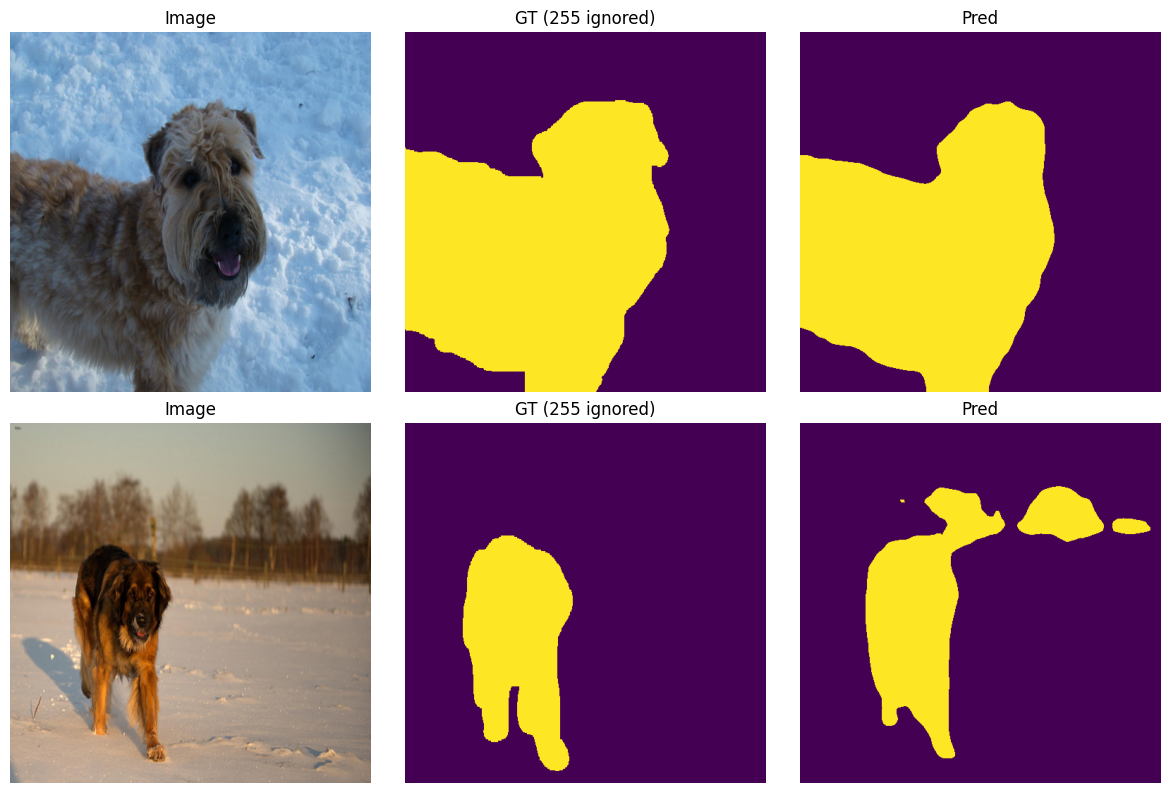

In [18]:
import matplotlib.pyplot as plt

def viz_batch(batch, logits):
    # logits: [B,C,h,w] -> upsample -> argmax
    if logits.shape[-2:] != batch["labels"].shape[-2:]:
        logits = F.interpolate(logits, size=batch["labels"].shape[-2:], mode="bilinear", align_corners=False)
    preds = logits.argmax(1).cpu().numpy()
    gts   = batch["labels"].cpu().numpy()
    ims   = batch["pixel_values"].cpu().numpy().transpose(0,2,3,1)  # to HWC, still normalized

    # unnormalize for display
    mean = np.array([0.485, 0.456, 0.406]).reshape(1,1,3)
    std  = np.array([0.229, 0.224, 0.225]).reshape(1,1,3)
    ims = (ims * std + mean).clip(0,1)

    cols = 3
    rows = min(2, ims.shape[0])
    plt.figure(figsize=(cols*4, rows*4))
    for i in range(rows):
        plt.subplot(rows, cols, i*cols+1); plt.imshow(ims[i]); plt.axis("off"); plt.title("Image")
        plt.subplot(rows, cols, i*cols+2); plt.imshow(gts[i], vmin=0, vmax=1); plt.axis("off"); plt.title("GT (255 ignored)")
        plt.subplot(rows, cols, i*cols+3); plt.imshow(preds[i], vmin=0, vmax=1); plt.axis("off"); plt.title("Pred")
    plt.tight_layout()
    plt.show()

# Grab one batch from val and visualize
model.eval()
batch = next(iter(val_loader))
with torch.no_grad():
    logits = model(pixel_values=batch["pixel_values"].to(device)).logits
viz_batch(batch, logits)
